In [ ]:
!pip install pyEDFlib mne numpy pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 79.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/seizeL2-sample.zip"
extract_dir = "/content/seizeL2_subset"

# Only unzip if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Dataset extracted")
else:
    print("Already extracted")


Dataset extracted


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
!mkdir -p classes

!wget https://raw.githubusercontent.com/biomedepi/seizeit2/refs/heads/main/classes/annotation.py -O classes/annotation.py
!wget https://raw.githubusercontent.com/biomedepi/seizeit2/refs/heads/main/classes/data.py -O classes/data.py

--2025-07-15 06:03:25--  https://raw.githubusercontent.com/biomedepi/seizeit2/refs/heads/main/classes/annotation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2533 (2.5K) [text/plain]
Saving to: ‘classes/annotation.py’

classes/annotation. 100%[===================>]   2.47K  --.-KB/s    in 0s      

2025-07-15 06:03:25 (25.2 MB/s) - ‘classes/annotation.py’ saved [2533/2533]

--2025-07-15 06:03:26--  https://raw.githubusercontent.com/biomedepi/seizeit2/refs/heads/main/classes/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [ ]:
import sys
sys.path.append("/content/classes")

from data import Data
from annotation import Annotation

In [ ]:
data_path = Path("/content/seizeL2_subset/seizeL2-sample")

sub_list = [x for x in data_path.glob("sub*")]
recordings = [[x.name, xx.name.split('_')[-2]] for x in sub_list for xx in (x / 'ses-01' / 'eeg').glob("*edf")]

# filter recordings to choose only recordings from certain patient:
recordings = [x for x in recordings if 'sub-001' in x[0]]

data = list()
annotations = list()

for rec in recordings:
    print(rec[0] + ' ' + rec[1])
    rec_data = Data.loadData(data_path.as_posix(), rec, modalities=['eeg', 'ecg', 'mov'])
    rec_annotations = Annotation.loadAnnotation(data_path.as_posix(), rec)

    data.append(rec_data)
    annotations.append(rec_annotations)

sub-001 run-05
sub-001 run-06
sub-001 run-09
sub-001 run-04
sub-001 run-03
sub-001 run-08
sub-001 run-01
sub-001 run-07
sub-001 run-02


In [ ]:
import matplotlib.pyplot as plt

sample_data = data[0]
sample_annot = annotations[0]

# seizure_events = sample_annot[sample_annot['eventType'].str.contains('sz')]
seizure_events = sample_annot.df[sample_annot.df['eventType'].str.contains('sz')]

print("Number of seizure events:", len(seizure_events))
print(seizure_events[['onset', 'duration', 'eventType']].head())

# Pick the first seizure event for plotting
onset = seizure_events.iloc[0]['onset']        # in seconds
duration = seizure_events.iloc[0]['duration']  # in seconds

# Plot EEG
sample_data['eeg'].plot(start=onset, duration=duration, scalings='auto', title='EEG during seizure')

# Plot ECG
if 'ecg' in sample_data:
    sample_data['ecg'].plot(start=onset, duration=duration, scalings='auto', title='ECG during seizure')


AttributeError: 'Annotation' object has no attribute 'df'

✅ Total seizure events: 2
#1: Type=sz_foc_a_nm, Start=4046.0s, Duration=20.0s
#2: Type=sz_foc_ia_m_hyperkinetic, Start=10629.0s, Duration=181.0s


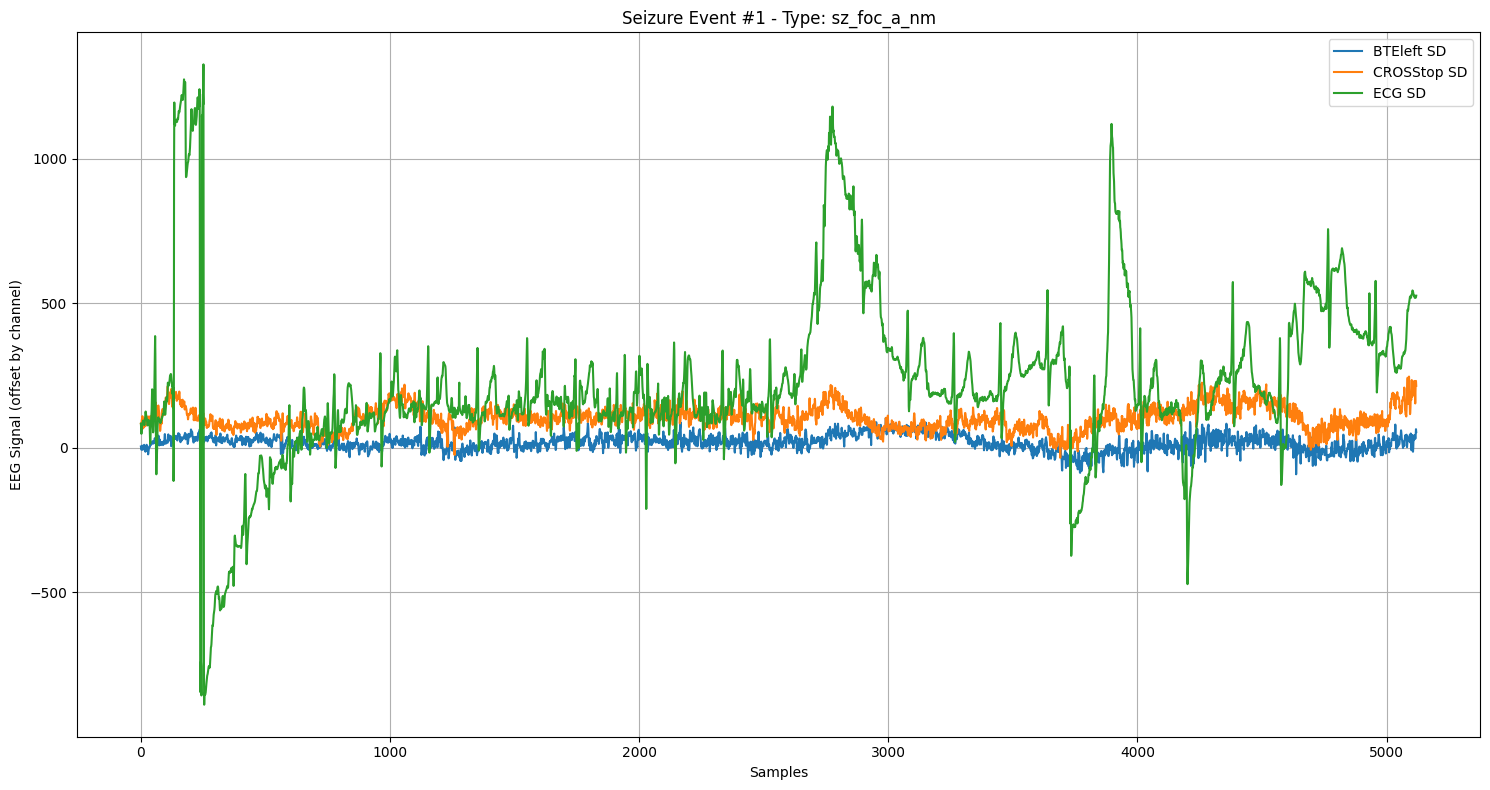

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from data import Data
from annotation import Annotation
import numpy as np

# 🗂️ STEP 4: Set data path and pick one patient
data_path = Path("/content/seizeL2_subset/seizeL2-sample")
patient_id = "sub-002"
recording_run = "run-01"  # Adjust as needed

# 🎧 STEP 5: Load Data (EEG, ECG, MOV if available)
recording = [patient_id, recording_run]
sample_data = Data.loadData(str(data_path), recording, modalities=['eeg', 'ecg'])  # Add 'mov' if you want

# 🧠 STEP 6: Load Annotations
sample_annot = Annotation.loadAnnotation(str(data_path), recording)

# 🧪 STEP 7: Display seizure event metadata
print(f"✅ Total seizure events: {len(sample_annot.events)}")
for i, event in enumerate(sample_annot.events):
    print(f"#{i+1}: Type={sample_annot.types[i]}, Start={event[0]}s, Duration={event[1] - event[0]}s")

# 📊 STEP 8: Plot one seizure event from EEG
event_index = 0  # Change index to plot other seizures
start_sec, end_sec = sample_annot.events[event_index]
fs = sample_data.fs[0]  # Assuming consistent sampling rate

# Convert time to samples
start_idx = int(start_sec * fs)
end_idx = int(end_sec * fs)

# Plot all EEG channels
eeg_signals = sample_data.data  # This is a list of arrays
channels = sample_data.channels

plt.figure(figsize=(15, 8))
for ch_idx, signal in enumerate(eeg_signals):
    segment = signal[start_idx:end_idx]
    plt.plot(segment + ch_idx * 100, label=channels[ch_idx])  # Offset for visibility

plt.title(f"Seizure Event #{event_index+1} - Type: {sample_annot.types[event_index]}")
plt.xlabel("Samples")
plt.ylabel("EEG Signal (offset by channel)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(annotations)

[<annotation.Annotation object at 0x79432cc99690>, <annotation.Annotation object at 0x79432c028a10>, <annotation.Annotation object at 0x79432c035610>, <annotation.Annotation object at 0x794350a6b450>, <annotation.Annotation object at 0x79432c036090>, <annotation.Annotation object at 0x79432c029150>, <annotation.Annotation object at 0x79432c02b990>, <annotation.Annotation object at 0x79427136dad0>, <annotation.Annotation object at 0x79432c02ac50>]


In [ ]:
print("Available attributes:")
print(dir(sample_annot))

Available attributes:
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'events', 'lateralization', 'loadAnnotation', 'localization', 'rec_duration', 'types', 'vigilance']


In [ ]:
import matplotlib.pyplot as plt

# Step 1: Grab first patient's data and annotations
sample_data = data[0]
sample_annot = annotations[0]

# ✅ Step 2: Use the `events` DataFrame inside the Annotation object
events_df = sample_annot.events

# Step 3: Filter for seizure events (look for rows containing 'sz')
seizure_events = events_df[events_df['eventType'].str.contains('sz')]

print("🧠 Number of seizure events:", len(seizure_events))
print(seizure_events[['onset', 'duration', 'eventType']].head())

# Step 4: Visualize one seizure event
onset = seizure_events.iloc[0]['onset']
duration = seizure_events.iloc[0]['duration']

# Step 5: Plot EEG
print("🔍 EEG plot...")
sample_data['eeg'].plot(start=onset, duration=duration, scalings='auto', title='EEG during Seizure')

# Optional: Plot ECG if present
if 'ecg' in sample_data:
    print("❤️ ECG plot...")
    sample_data['ecg'].plot(start=onset, duration=duration, scalings='auto', title='ECG during Seizure')


TypeError: list indices must be integers or slices, not str

In [ ]:
print("🔎 Type of events_df:", type(events_df))
print("📏 Length of events_df:", len(events_df))
print("📌 First element sample:")
print(events_df[0])

🔎 Type of events_df: <class 'list'>
📏 Length of events_df: 1
📌 First element sample:
[60968.0, 61049.0]


In [ ]:
import pandas as pd

events_df = pd.DataFrame(events_df)
print(events_df.head())  # sanity check

         0        1
0  60968.0  61049.0


In [ ]:
seizure_events = events_df[events_df['eventType'].str.contains('sz')]

KeyError: 'eventType'

In [ ]:
import pandas as pd

# Convert list of [start, end] into DataFrame with durations
events_clean_df = pd.DataFrame(events_df, columns=["onset", "offset"])
events_clean_df["duration"] = events_clean_df["offset"] - events_clean_df["onset"]

print(events_clean_df.head())

# Pick the first event to plot
onset = events_clean_df.iloc[0]["onset"]
duration = events_clean_df.iloc[0]["duration"]

# Now plot
sample_data["eeg"].plot(start=onset, duration=duration, scalings="auto", title="EEG during seizure")print("🔍 Type of sample_data:", type(sample_data))
print("📦 Attributes:", dir(sample_data))


   onset  offset  duration
0    NaN     NaN       NaN


TypeError: 'Data' object is not subscriptable

In [ ]:
print("🔍 Type of sample_data:", type(sample_data))
print("📦 Attributes:", dir(sample_data))

🔍 Type of sample_data: <class 'data.Data'>
📦 Attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'channels', 'data', 'fs', 'loadData']


In [ ]:
print("Total channels:", len(sample_data.channels))
for i, ch in enumerate(sample_data.channels):
    print(f"Channel {i}: {ch}")

📊 Total channels: 15
Channel 0: BTEleft SD
Channel 1: CROSStop SD
Channel 2: ECG SD
Channel 3: EEG SD ACC X
Channel 4: EEG SD ACC Y
Channel 5: EEG SD ACC Z
Channel 6: EEG SD GYR A
Channel 7: EEG SD GYR B
Channel 8: EEG SD GYR C
Channel 9: ECGEMG SD ACC X
Channel 10: ECGEMG SD ACC Y
Channel 11: ECGEMG SD ACC Z
Channel 12: ECGEMG SD GYR A
Channel 13: ECGEMG SD GYR B
Channel 14: ECGEMG SD GYR C
